In [2]:
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cwd_dir = (os.path.abspath(os.path.join(os.getcwd())))
sys.path.insert(0, cwd_dir)
import utils.constants as constants
from utils.utils import *

create_grid_domains()

/Volumes/T9/checkpoints/best/0_model.pt
/Volumes/T9/checkpoints/best/1_model.pt
/Volumes/T9/checkpoints/best/2_model.pt
/Volumes/T9/checkpoints/best/3_model.pt
/Volumes/T9/checkpoints/best/4_model.pt
/Volumes/T9/checkpoints/best/5_model.pt
/Volumes/T9/checkpoints/best/7_model.pt
/Volumes/T9/checkpoints/best/8_model.pt
/Volumes/T9/checkpoints/best/9_model.pt
/Volumes/T9/checkpoints/best/10_model.pt
/Volumes/T9/checkpoints/best/11_model.pt
/Volumes/T9/checkpoints/best/12_model.pt
/Volumes/T9/checkpoints/best/14_model.pt
/Volumes/T9/checkpoints/best/15_model.pt
/Volumes/T9/checkpoints/best/16_model.pt
/Volumes/T9/checkpoints/best/17_model.pt
/Volumes/T9/checkpoints/best/18_model.pt
/Volumes/T9/checkpoints/best/19_model.pt
/Volumes/T9/checkpoints/best/21_model.pt
/Volumes/T9/checkpoints/best/22_model.pt
/Volumes/T9/checkpoints/best/23_model.pt
/Volumes/T9/checkpoints/best/24_model.pt
/Volumes/T9/checkpoints/best/25_model.pt
/Volumes/T9/checkpoints/best/26_model.pt
/Volumes/T9/checkpoints/b

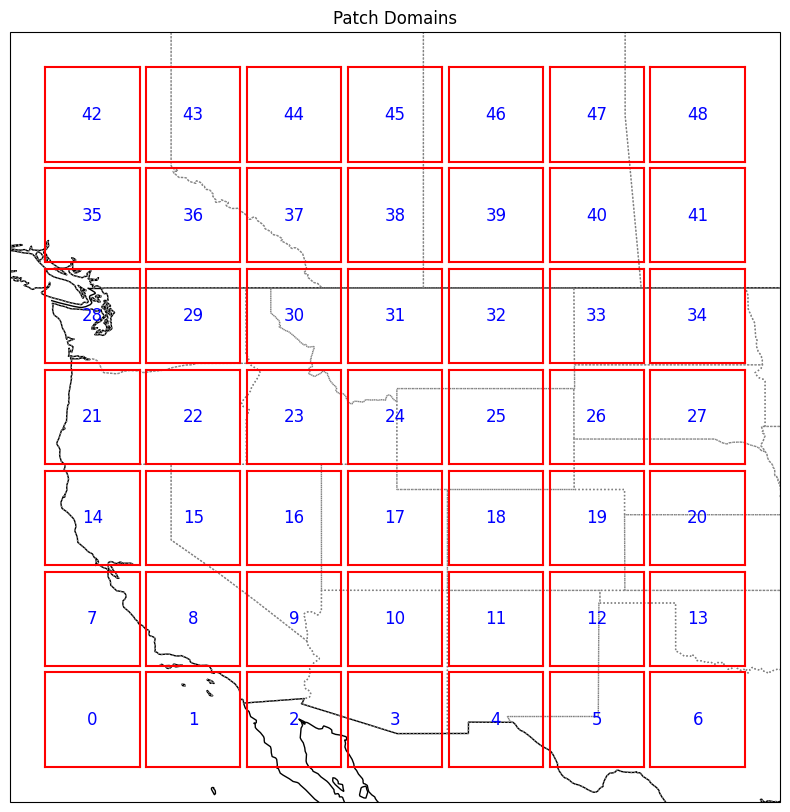

In [3]:
def plot_grid_domains(grid_file):
    # Load the grid domains
    with open(grid_file, 'rb') as f:
        grid_domains = pickle.load(f)

    # Create a figure and axis with the correct projection
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    # ax.set_extent([-125, -97, 30, 60], ccrs.PlateCarree())  # Western US region

    # Add features to the map
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    # Plot each grid domain
    for domain_id, (lat_start, lat_end, lon_start, lon_end) in grid_domains.items():

        # check if checkpoint file exists at constants.base_dir
        checkpoint_file = f'{constants.checkpoints_dir}best/{domain_id}_model.pt'
        if os.path.exists(checkpoint_file):
            print(checkpoint_file)

        lat_values = np.arange(lat_start, lat_end, 0.25)
        lon_values = np.arange(lon_start, lon_end, 0.25)
        
        # Define the corner points of the grid box
        lon_min, lon_max = lon_values[0], lon_values[-1]
        lat_min, lat_max = lat_values[0], lat_values[-1]
        
        # Plot the rectangle for the grid domain
        ax.plot([lon_min, lon_max], [lat_min, lat_min], color='red')
        ax.plot([lon_min, lon_max], [lat_max, lat_max], color='red')
        ax.plot([lon_min, lon_min], [lat_min, lat_max], color='red')
        ax.plot([lon_max, lon_max], [lat_min, lat_max], color='red')
        
        # Place the domain ID in the center of the grid box
        ax.text((lon_min + lon_max) / 2, (lat_min + lat_max) / 2, str(domain_id), 
                color='blue', fontsize=12, ha='center', va='center')
    
    plt.title('Patch Domains')
    plt.savefig('figures/patches.png')

# Usage
grid_file = f'{constants.domains_dir}/grid_domains.pkl'
plot_grid_domains(grid_file)

Domain 0: Test Loss = 0.0342, Percent Error Reduction = 15.68%
/Volumes/T9/checkpoints/best/0_model.pt
Domain 1: Test Loss = 0.0363, Percent Error Reduction = 13.10%
/Volumes/T9/checkpoints/best/1_model.pt
Domain 2: Test Loss = 0.0995, Percent Error Reduction = 0.12%
/Volumes/T9/checkpoints/best/2_model.pt
Domain 3: Test Loss = 0.2617, Percent Error Reduction = 21.04%
/Volumes/T9/checkpoints/best/3_model.pt
Domain 4: Test Loss = 0.2952, Percent Error Reduction = 18.93%
/Volumes/T9/checkpoints/best/4_model.pt
Domain 5: Test Loss = 0.4478, Percent Error Reduction = 15.74%
/Volumes/T9/checkpoints/best/5_model.pt
Domain 7: Test Loss = 0.0557, Percent Error Reduction = 2.95%
/Volumes/T9/checkpoints/best/7_model.pt
Domain 8: Test Loss = 0.0670, Percent Error Reduction = 24.36%
/Volumes/T9/checkpoints/best/8_model.pt
Domain 9: Test Loss = 0.0746, Percent Error Reduction = 12.26%
/Volumes/T9/checkpoints/best/9_model.pt
Domain 10: Test Loss = 0.1898, Percent Error Reduction = -5.99%
/Volumes/T9

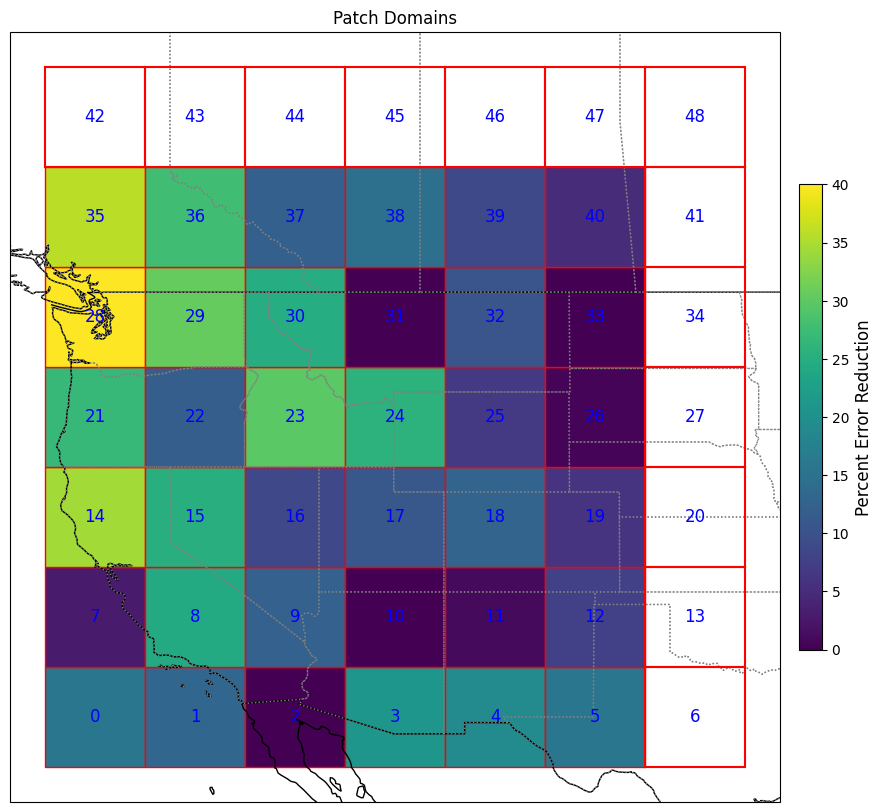

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import pickle
import torch  # Assuming PyTorch is used for loading checkpoint files
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_grid_domains(grid_file):
    # Load the grid domains
    with open(grid_file, 'rb') as f:
        grid_domains = pickle.load(f)

    # Create a figure and axis with the correct projection
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add features to the map
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    # Define a colormap and normalization for test_loss
    cmap = cm.viridis
    norm = Normalize(vmin=0, vmax=40)  # Set the normalization range for 0 to 100

    # Prepare for the colorbar by creating a ScalarMappable
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy data for colorbar

    # Plot each grid domain
    for domain_id, (lat_start, lat_end, lon_start, lon_end) in grid_domains.items():
        # Check if checkpoint file exists
        checkpoint_file = f'{constants.checkpoints_dir}best/{domain_id}_model.pt'
        if os.path.exists(checkpoint_file):
            # Load the checkpoint file
            checkpoint = torch.load(checkpoint_file)
            test_loss = checkpoint.get('test_loss', 0)  # Default to 0 if test_loss isn't in the checkpoint
            bilinear_loss = checkpoint.get('bilinear_loss', 1)  # Ensure bilinear_loss isn't zero
            percent_error_reduction = (1 - (np.sqrt(test_loss) / np.sqrt(bilinear_loss))) * 100
            print(f'Domain {domain_id}: Test Loss = {test_loss:.4f}, Percent Error Reduction = {percent_error_reduction:.2f}%')

            # Normalize the percent_error_reduction to [0, 1] for colormap mapping
            color = cmap(norm(percent_error_reduction))  # Map normalized percent_error_reduction to a color

            # Define the corner points of the grid box
            lon_min, lon_max = lon_start, lon_end
            lat_min, lat_max = lat_start, lat_end
            
            # Create a filled rectangle for the grid domain
            rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                             linewidth=1, edgecolor='red', facecolor=color, transform=ccrs.PlateCarree())
            ax.add_patch(rect)
            
            # Print the checkpoint file path
            print(checkpoint_file)
        else:
            # Plot the rectangle for the grid domain without coloring
            lon_min, lon_max = lon_start, lon_end
            lat_min, lat_max = lat_start, lat_end
            ax.plot([lon_min, lon_max], [lat_min, lat_min], color='red')
            ax.plot([lon_min, lon_max], [lat_max, lat_max], color='red')
            ax.plot([lon_min, lon_min], [lat_min, lat_max], color='red')
            ax.plot([lon_max, lon_max], [lat_min, lat_max], color='red')

        # Place the domain ID in the center of the grid box
        ax.text((lon_min + lon_max) / 2, (lat_min + lat_max) / 2, str(domain_id), 
                color='blue', fontsize=12, ha='center', va='center')
    
    # Add the colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.02)
    cbar.set_label('Percent Error Reduction', fontsize=12)

    plt.title('Patch Domains')
    plt.savefig('figures/patches.png')
    plt.show()

# Usage
grid_file = f'{constants.domains_dir}/grid_domains.pkl'
plot_grid_domains(grid_file)